## Step 1: Imports

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

## Step 2: Global Configuration

In [2]:
DATA_ROOT = r"E:\InstruNet-AI\data\post_preprocessing\irmas_mono"

INPUT_SHAPE = (128, 126, 1)
NUM_CLASSES = 11
WINDOW_SEC = 3.0
HOP_SEC = 1.5
SR = 16000

BATCH_SIZE = 128
EPOCHS = 50

## Step 3: Load Label Map

In [3]:
import json

with open(r"E:\InstruNet-AI\data\splits\label_map.json", "r") as f:
    class_to_id = json.load(f)

id_to_class = {v: k for k, v in class_to_id.items()}

## Step 4: Data Loader (Multi-Label Ready)

In [4]:
def load_split(split):
    X, y = [], []

    split_dir = os.path.join(DATA_ROOT, split)

    for cls in os.listdir(split_dir):
        cls_id = class_to_id[cls]
        cls_dir = os.path.join(split_dir, cls)

        for file in os.listdir(cls_dir):
            if file.endswith(".npy"):
                mel = np.load(os.path.join(cls_dir, file))
                mel = mel[..., np.newaxis]

                label = np.zeros(NUM_CLASSES)
                label[cls_id] = 1  # multi-label compatible

                X.append(mel)
                y.append(label)

    return np.array(X), np.array(y)

## Step 5: Load Train / Val / Test

In [5]:
X_train, y_train = load_split("train")
X_val, y_val     = load_split("val")
X_test, y_test   = load_split("test")

print(X_train.shape, y_train.shape)

(4692, 128, 126, 1) (4692, 11)


## Step 6: CNN Architecture (For baseline model to avoid regularization)

In [6]:
def build_instrunet_baseline():
    inputs = layers.Input(shape=INPUT_SHAPE)

    x = layers.Conv2D(32, (5,5), padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (5,5), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (5,5), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(256, (5,5), padding="same", activation="relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    outputs = layers.Dense(NUM_CLASSES, activation="sigmoid")(x)

    return models.Model(inputs, outputs)

## Step 7: Compile Model (BCE + SGD)

In [7]:
model = build_instrunet_baseline()

optimizer = optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-7
)

model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="binary_accuracy")
    ]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 126, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 126, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 63, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 31, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 15, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 11)                  │           2,827 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,079,307 (4.12 MB)

 Trainable params: 1,079,307 (4.12 MB)

 Non-trainable params: 0 (0.00 B)

## Step 8: Callbacks

In [8]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    ),
    ModelCheckpoint(
        filepath='best_baseline_model_2.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

## Step 9: Class Weights Preparation

In [9]:
# Inverse frequency weighting
class_counts = y_train.sum(axis=0)
total_samples = y_train.shape[0]
num_classes = y_train.shape[1]

class_weights = {
    i: total_samples / (num_classes * class_counts[i])
    for i in range(num_classes)
}

## Step 10: Train Model

In [10]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights if class_weights else None,
    verbose=1
)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.8795 - loss: 0.4496

37/37 ━━━━━━━━━━━━━━━━━━━━ 187s 5s/step - binary_accuracy: 0.9011 - loss: 0.3693 - val_binary_accuracy: 0.9091 - val_loss: 0.3148 - learning_rate: 0.0010
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 204s 5s/step - binary_accuracy: 0.9091 - loss: 0.3218 - val_binary_accuracy: 0.9091 - val_loss: 0.3236 - learning_rate: 0.0010
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9091 - loss: 0.3177

37/37 ━━━━━━━━━━━━━━━━━━━━ 190s 5s/step - binary_accuracy: 0.9091 - loss: 0.3169 - val_binary_accuracy: 0.9091 - val_loss: 0.3134 - learning_rate: 0.0010
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9091 - loss: 0.3126

37/37 ━━━━━━━━━━━━━━━━━━━━ 185s 5s/step - binary_accuracy: 0.9091 - loss: 0.3130 - val_binary_accuracy: 0.9091 - val_loss: 0.3121 - learning_rate: 0.0010
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9091 - loss: 0.3102

37/37 ━━━━━━━━━━━━━━━━━━━━ 205s 5s/step - binary_accuracy: 0.9091 - loss: 0.3097 - val_binary_accuracy: 0.9091 - val_loss: 0.3044 - learning_rate: 0.0010
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9091 - loss: 0.3069

37/37 ━━━━━━━━━━━━━━━━━━━━ 200s 5s/step - binary_accuracy: 0.9091 - loss: 0.3053 - val_binary_accuracy: 0.9091 - val_loss: 0.2973 - learning_rate: 0.0010
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 186s 5s/step - binary_accuracy: 0.9091 - loss: 0.2979 - val_binary_accuracy: 0.9093 - val_loss: 0.2974 - learning_rate: 0.0010
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9090 - loss: 0.2945

37/37 ━━━━━━━━━━━━━━━━━━━━ 198s 5s/step - binary_accuracy: 0.9089 - loss: 0.2947 - val_binary_accuracy: 0.9091 - val_loss: 0.2872 - learning_rate: 0.0010
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 189s 5s/step - binary_accuracy: 0.9095 - loss: 0.2902 - val_binary_accuracy: 0.9092 - val_loss: 0.2903 - learning_rate: 0.0010
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9095 - loss: 0.2869

37/37 ━━━━━━━━━━━━━━━━━━━━ 194s 5s/step - binary_accuracy: 0.9093 - loss: 0.2857 - val_binary_accuracy: 0.9092 - val_loss: 0.2842 - learning_rate: 0.0010
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 194s 5s/step - binary_accuracy: 0.9093 - loss: 0.2820 - val_binary_accuracy: 0.9091 - val_loss: 0.2898 - learning_rate: 0.0010
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9096 - loss: 0.2792

37/37 ━━━━━━━━━━━━━━━━━━━━ 196s 5s/step - binary_accuracy: 0.9096 - loss: 0.2786 - val_binary_accuracy: 0.9093 - val_loss: 0.2800 - learning_rate: 0.0010
Epoch 13/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9097 - loss: 0.2740

37/37 ━━━━━━━━━━━━━━━━━━━━ 182s 5s/step - binary_accuracy: 0.9098 - loss: 0.2733 - val_binary_accuracy: 0.9092 - val_loss: 0.2697 - learning_rate: 0.0010
Epoch 14/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 203s 5s/step - binary_accuracy: 0.9097 - loss: 0.2709 - val_binary_accuracy: 0.9075 - val_loss: 0.2797 - learning_rate: 0.0010
Epoch 15/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9093 - loss: 0.2695

37/37 ━━━━━━━━━━━━━━━━━━━━ 181s 5s/step - binary_accuracy: 0.9100 - loss: 0.2658 - val_binary_accuracy: 0.9099 - val_loss: 0.2645 - learning_rate: 0.0010
Epoch 16/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9107 - loss: 0.2613

37/37 ━━━━━━━━━━━━━━━━━━━━ 181s 5s/step - binary_accuracy: 0.9110 - loss: 0.2603 - val_binary_accuracy: 0.9101 - val_loss: 0.2570 - learning_rate: 0.0010
Epoch 17/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 184s 5s/step - binary_accuracy: 0.9119 - loss: 0.2545 - val_binary_accuracy: 0.9030 - val_loss: 0.2874 - learning_rate: 0.0010
Epoch 18/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 195s 5s/step - binary_accuracy: 0.9117 - loss: 0.2529 - val_binary_accuracy: 0.9048 - val_loss: 0.2853 - learning_rate: 0.0010
Epoch 19/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 176s 5s/step - binary_accuracy: 0.9122 - loss: 0.2480 - val_binary_accuracy: 0.9099 - val_loss: 0.2587 - learning_rate: 0.0010
Epoch 20/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 212s 5s/step - binary_accuracy: 0.9128 - loss: 0.2446 - val_binary_accuracy: 0.9082 - val_loss: 0.2647 - learning_rate: 0.0010
Epoch 21/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - binary_accuracy: 0.9113 - loss: 0.2490

37/37 ━━━━━━━━━━━━━━━━━━━━ 193s 5s/step - binary_accuracy: 0.9132 - loss: 0.2439 - val_binary_accuracy: 0.9123 - val_loss: 0.2499 - learning_rate: 0.0010
Epoch 22/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - binary_accuracy: 0.9148 - loss: 0.2355

37/37 ━━━━━━━━━━━━━━━━━━━━ 203s 5s/step - binary_accuracy: 0.9145 - loss: 0.2373 - val_binary_accuracy: 0.9130 - val_loss: 0.2408 - learning_rate: 0.0010
Epoch 23/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 177s 5s/step - binary_accuracy: 0.9147 - loss: 0.2369 - val_binary_accuracy: 0.9132 - val_loss: 0.2489 - learning_rate: 0.0010
Epoch 24/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9185 - loss: 0.2302

37/37 ━━━━━━━━━━━━━━━━━━━━ 178s 5s/step - binary_accuracy: 0.9176 - loss: 0.2315 - val_binary_accuracy: 0.9137 - val_loss: 0.2389 - learning_rate: 0.0010
Epoch 25/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 177s 5s/step - binary_accuracy: 0.9180 - loss: 0.2285 - val_binary_accuracy: 0.9100 - val_loss: 0.2515 - learning_rate: 0.0010
Epoch 26/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 204s 5s/step - binary_accuracy: 0.9176 - loss: 0.2275 - val_binary_accuracy: 0.9114 - val_loss: 0.2693 - learning_rate: 0.0010
Epoch 27/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9177 - loss: 0.2296

37/37 ━━━━━━━━━━━━━━━━━━━━ 210s 5s/step - binary_accuracy: 0.9190 - loss: 0.2244 - val_binary_accuracy: 0.9129 - val_loss: 0.2380 - learning_rate: 0.0010
Epoch 28/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9190 - loss: 0.2220

37/37 ━━━━━━━━━━━━━━━━━━━━ 186s 5s/step - binary_accuracy: 0.9190 - loss: 0.2217 - val_binary_accuracy: 0.9167 - val_loss: 0.2304 - learning_rate: 0.0010
Epoch 29/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 202s 5s/step - binary_accuracy: 0.9214 - loss: 0.2188 - val_binary_accuracy: 0.9152 - val_loss: 0.2339 - learning_rate: 0.0010
Epoch 30/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 200s 5s/step - binary_accuracy: 0.9223 - loss: 0.2134 - val_binary_accuracy: 0.9160 - val_loss: 0.2315 - learning_rate: 0.0010
Epoch 31/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9219 - loss: 0.2134

37/37 ━━━━━━━━━━━━━━━━━━━━ 204s 5s/step - binary_accuracy: 0.9223 - loss: 0.2139 - val_binary_accuracy: 0.9199 - val_loss: 0.2263 - learning_rate: 0.0010
Epoch 32/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 201s 5s/step - binary_accuracy: 0.9223 - loss: 0.2125 - val_binary_accuracy: 0.9175 - val_loss: 0.2276 - learning_rate: 0.0010
Epoch 33/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9260 - loss: 0.2073

37/37 ━━━━━━━━━━━━━━━━━━━━ 209s 5s/step - binary_accuracy: 0.9240 - loss: 0.2093 - val_binary_accuracy: 0.9230 - val_loss: 0.2081 - learning_rate: 0.0010
Epoch 34/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 190s 5s/step - binary_accuracy: 0.9250 - loss: 0.2071 - val_binary_accuracy: 0.9218 - val_loss: 0.2137 - learning_rate: 0.0010
Epoch 35/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9258 - loss: 0.2049

37/37 ━━━━━━━━━━━━━━━━━━━━ 178s 5s/step - binary_accuracy: 0.9271 - loss: 0.2032 - val_binary_accuracy: 0.9224 - val_loss: 0.2065 - learning_rate: 0.0010
Epoch 36/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 180s 5s/step - binary_accuracy: 0.9270 - loss: 0.2017 - val_binary_accuracy: 0.9151 - val_loss: 0.2413 - learning_rate: 0.0010
Epoch 37/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 200s 5s/step - binary_accuracy: 0.9284 - loss: 0.1961 - val_binary_accuracy: 0.9198 - val_loss: 0.2267 - learning_rate: 0.0010
Epoch 38/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9293 - loss: 0.1969

37/37 ━━━━━━━━━━━━━━━━━━━━ 187s 5s/step - binary_accuracy: 0.9291 - loss: 0.1962 - val_binary_accuracy: 0.9263 - val_loss: 0.2002 - learning_rate: 0.0010
Epoch 39/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9307 - loss: 0.1905

37/37 ━━━━━━━━━━━━━━━━━━━━ 208s 5s/step - binary_accuracy: 0.9291 - loss: 0.1932 - val_binary_accuracy: 0.9287 - val_loss: 0.1949 - learning_rate: 0.0010
Epoch 40/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 185s 5s/step - binary_accuracy: 0.9314 - loss: 0.1886 - val_binary_accuracy: 0.9242 - val_loss: 0.2029 - learning_rate: 0.0010
Epoch 41/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 185s 5s/step - binary_accuracy: 0.9317 - loss: 0.1884 - val_binary_accuracy: 0.9180 - val_loss: 0.2321 - learning_rate: 0.0010
Epoch 42/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 184s 5s/step - binary_accuracy: 0.9321 - loss: 0.1853 - val_binary_accuracy: 0.9287 - val_loss: 0.1985 - learning_rate: 0.0010
Epoch 43/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 202s 5s/step - binary_accuracy: 0.9342 - loss: 0.1814 - val_binary_accuracy: 0.9230 - val_loss: 0.2171 - learning_rate: 0.0010
Epoch 44/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9337 - loss: 0.1816

37/37 ━━━━━━━━━━━━━━━━━━━━ 186s 5s/step - binary_accuracy: 0.9338 - loss: 0.1809 - val_binary_accuracy: 0.9321 - val_loss: 0.1834 - learning_rate: 0.0010
Epoch 45/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 201s 5s/step - binary_accuracy: 0.9343 - loss: 0.1790 - val_binary_accuracy: 0.9315 - val_loss: 0.1928 - learning_rate: 0.0010
Epoch 46/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 186s 5s/step - binary_accuracy: 0.9368 - loss: 0.1744 - val_binary_accuracy: 0.9251 - val_loss: 0.2009 - learning_rate: 0.0010
Epoch 47/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9346 - loss: 0.1774

37/37 ━━━━━━━━━━━━━━━━━━━━ 194s 5s/step - binary_accuracy: 0.9353 - loss: 0.1752 - val_binary_accuracy: 0.9324 - val_loss: 0.1812 - learning_rate: 0.0010
Epoch 48/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 192s 5s/step - binary_accuracy: 0.9379 - loss: 0.1695 - val_binary_accuracy: 0.9348 - val_loss: 0.1863 - learning_rate: 0.0010
Epoch 49/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 202s 5s/step - binary_accuracy: 0.9377 - loss: 0.1685 - val_binary_accuracy: 0.9264 - val_loss: 0.2029 - learning_rate: 0.0010
Epoch 50/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 186s 5s/step - binary_accuracy: 0.9386 - loss: 0.1671 - val_binary_accuracy: 0.9301 - val_loss: 0.1910 - learning_rate: 0.0010


## Step 11: Accuracy Curve

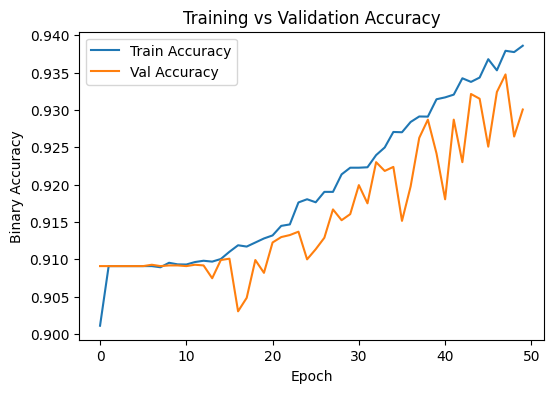

In [11]:
plt.figure(figsize=(6,4))
plt.plot(history.history["binary_accuracy"], label="Train Accuracy")
plt.plot(history.history["val_binary_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Binary Accuracy")
plt.show()

## Step 12: Training Loss and Validation Loss Curves

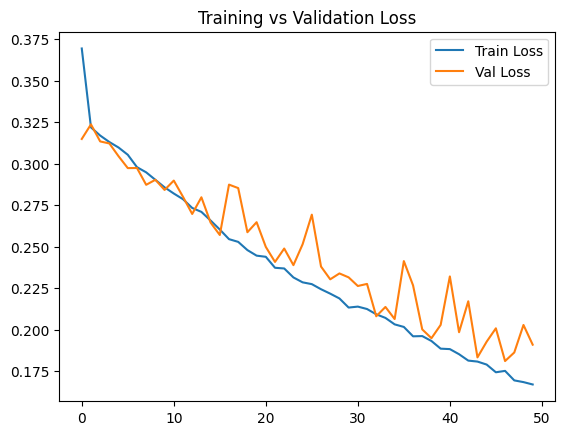

In [12]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

## Step 13: CNN Architecture (Model with regularization applied)

In [13]:
def build_instrunet_regularized():
    inputs = layers.Input(shape=INPUT_SHAPE)

    x = layers.Conv2D(32, (5,5), padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (5,5), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (5,5), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(256, (5,5), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(NUM_CLASSES, activation="sigmoid")(x)

    return models.Model(inputs, outputs)

## Step 14: Model compile (BCE + SGD)

In [14]:
model = build_instrunet_regularized()

optimizer = optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-7
)

model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="binary_accuracy")
    ]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 126, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 126, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 63, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 63, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 31, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 31, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 15, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 15, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 11)                  │           2,827 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,081,227 (4.12 MB)

 Trainable params: 1,080,267 (4.12 MB)

 Non-trainable params: 960 (3.75 KB)

## Step 15: Callbacks

In [15]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    ),
    ModelCheckpoint(
        filepath='best_baseline_regularized_2.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

In [16]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights if class_weights else None,
    verbose=1
)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.6428 - loss: 0.6571

37/37 ━━━━━━━━━━━━━━━━━━━━ 243s 6s/step - binary_accuracy: 0.7446 - loss: 0.5947 - val_binary_accuracy: 0.8449 - val_loss: 0.4912 - learning_rate: 0.0010
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.8989 - loss: 0.4127

37/37 ━━━━━━━━━━━━━━━━━━━━ 248s 7s/step - binary_accuracy: 0.9061 - loss: 0.3665 - val_binary_accuracy: 0.7655 - val_loss: 0.4266 - learning_rate: 0.0010
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3302s 92s/step - binary_accuracy: 0.9168 - loss: 0.2512 - val_binary_accuracy: 0.8388 - val_loss: 0.4854 - learning_rate: 0.0010
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 214s 6s/step - binary_accuracy: 0.9233 - loss: 0.2141 - val_binary_accuracy: 0.8376 - val_loss: 0.6851 - learning_rate: 0.0010
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 245s 7s/step - binary_accuracy: 0.9304 - loss: 0.1920 - val_binary_accuracy: 0.8388 - val_loss: 0.7961 - learning_rate: 0.0010
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 244s 7s/step - binary_accuracy: 0.9360 - loss: 0.1747 - val_binary_accuracy: 0.8388 - val_loss: 0.9662 - learning_rate: 0.0010
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 247s 7s/step - binary_accuracy: 0.9417 - loss: 0.1586 - val_binary_accuracy: 0.8382 - val_loss: 0.8891 - learning_rate: 0.0010
Epoch 8/50
37/37 ━━

## Step 16: Accuracy Curve

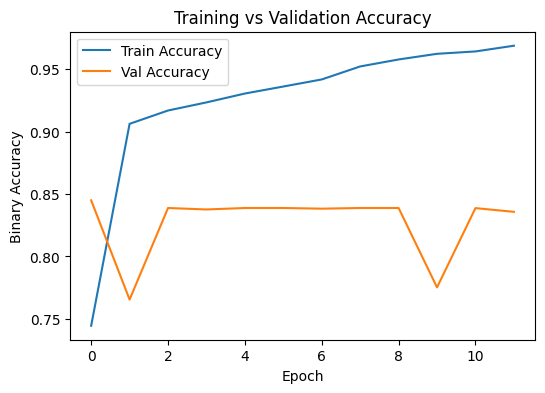

In [17]:
plt.figure(figsize=(6,4))
plt.plot(history.history["binary_accuracy"], label="Train Accuracy")
plt.plot(history.history["val_binary_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Binary Accuracy")
plt.show()

## Step 17:Training Loss and Validation Loss Curves

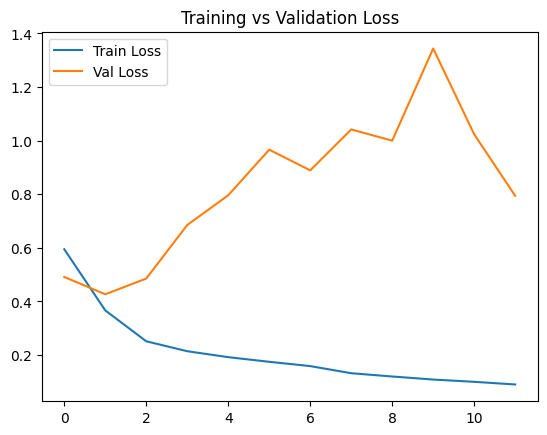

In [18]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

## Step 19: Model Evaluation with Thresholded Metrics

### (a) Generate probabilities

In [19]:
y_prob = model.predict(X_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 413ms/step


### (b) Apply thresholding

In [20]:
THRESHOLD = 0.3
y_pred = (y_prob >= THRESHOLD).astype(int)

print(f"Using decision threshold = {THRESHOLD}")

Using decision threshold = 0.3


### (c) Global F1 scores

In [21]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, f1_score, roc_curve, auc, roc_auc_score

In [22]:
micro_f1 = f1_score(y_test, y_pred, average="micro")
macro_f1 = f1_score(y_test, y_pred, average="macro")

print("=== Global Metrics ===")
print("Micro F1-score :", round(micro_f1, 4))
print("Macro F1-score :", round(macro_f1, 4))

=== Global Metrics ===
Micro F1-score : 0.14
Macro F1-score : 0.0484


### (d) Per-class Recall (CRITICAL)

In [23]:
recalls = recall_score(y_test, y_pred, average=None)

print("\n=== Per-class Recall ===")
for i, r in enumerate(recalls):
    print(f"{id_to_class[i]} : {round(r, 3)}")


=== Per-class Recall ===
cel : 0.966
cla : 0.0
flu : 0.0
gac : 1.0
gel : 1.0
org : 0.0
pia : 0.0
sax : 0.0
tru : 0.0
vio : 0.011
voi : 0.0


### (e) Per-class Precision

In [24]:
precisions = precision_score(
    y_test,
    y_pred,
    average=None,
    zero_division=0
)

print("\n=== Per-class Precision ===")
for i, p in enumerate(precisions):
    print(f"{id_to_class[i]} : {round(p, 3)}")


=== Per-class Precision ===
cel : 0.072
cla : 0.0
flu : 0.0
gac : 0.094
gel : 0.113
org : 0.0
pia : 0.0
sax : 0.0
tru : 0.0
vio : 0.5
voi : 0.0


### (f) Per-class Confusion Matrices

In [25]:
print("\n=== Per-class Confusion Matrices ===")
for i in range(NUM_CLASSES):
    print(f"\nConfusion Matrix for {id_to_class[i]}")
    print(confusion_matrix(y_test[:, i], y_pred[:, i]))


=== Per-class Confusion Matrices ===

Confusion Matrix for cel
[[224 724]
 [  2  56]]

Confusion Matrix for cla
[[930   0]
 [ 76   0]]

Confusion Matrix for flu
[[938   0]
 [ 68   0]]

Confusion Matrix for gac
[[  0 911]
 [  0  95]]

Confusion Matrix for gel
[[  0 892]
 [  0 114]]

Confusion Matrix for org
[[903   0]
 [103   0]]

Confusion Matrix for pia
[[898   0]
 [108   0]]

Confusion Matrix for sax
[[912   0]
 [ 94   0]]

Confusion Matrix for tru
[[920   0]
 [ 86   0]]

Confusion Matrix for vio
[[918   1]
 [ 86   1]]

Confusion Matrix for voi
[[889   0]
 [117   0]]


### (g) Plotting of ROC-AUC curve (AUC score per class)

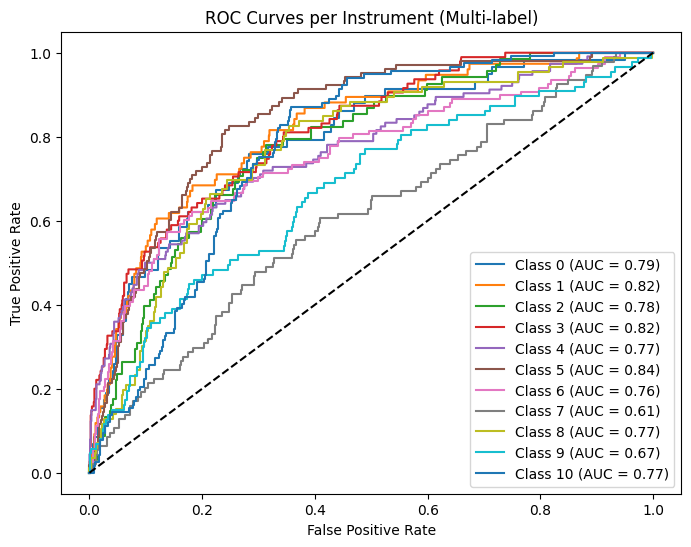

In [26]:
plt.figure(figsize=(8, 6))

for i in range(y_test.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_prob[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Instrument (Multi-label)")
plt.legend()
plt.show()

### (h) Micro-Averaged and Macro-Averaged F1 Score

In [27]:
micro_auc = roc_auc_score(y_test, y_prob, average="micro")
print("Micro-average ROC–AUC:", micro_auc)

Micro-average ROC–AUC: 0.5424085210407534


In [28]:
macro_auc = roc_auc_score(y_test, y_prob, average="macro")
print("Macro-average ROC–AUC:", macro_auc)

Macro-average ROC–AUC: 0.7635074002297347
